# Using vireo for multiplexing, followed by lineage tracing of those groups

# 1. Set up

In [1]:
import os
from os.path import join
os.chdir("/data2/mito_lineage/Analysis/multiplex")

In [2]:
pwd

'/data2/mito_lineage/Analysis/multiplex'

### Remove this when running in snakemake

## 1.1 Parameters

In [3]:
# Parameters
minC=200
minAF=0.01
samples=['Control', 'Flt3l', 'Input']
N_DONORS=5
INDIR= f"data/CHIP_april08_2021/MTblacklist/chrM/"

min_af_sum=0.01 # For AF-cluster visual filtering

In [4]:
OUTDIR=join(INDIR, "multiplex_individual")
if not os.path.exists(OUTDIR):
    os.mkdir(OUTDIR)

In [5]:
print("INDIR", INDIR)
print("N_DONORS", N_DONORS)
print("OUTDIR", OUTDIR)

INDIR data/CHIP_april08_2021/MTblacklist/chrM/
N_DONORS 5
OUTDIR data/CHIP_april08_2021/MTblacklist/chrM/multiplex_individual


In [6]:
# INDIR="data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse"
# OUTDIR= "data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3"
# N_DONORS=4 


## 1.2 Import packages

In [7]:
from os.path import join, exists, dirname
from glob import glob
import mplh.cluster_help as ch
import os
from vireoSNP.plot.base_plot import heat_matrix
from vireoSNP import Vireo
import src.pseudo_batch as pb
import vireoSNP
print(vireoSNP.__version__)
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from src.vireo.vireo_utils import run_vireo, plot_vireo_out, extract_clusters, run_elbo
%load_ext autoreload
%autoreload 2
%matplotlib inline


here
0.4.2


In [8]:
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

## Loop through each sample and run

sample Flt3l
Loading model
Running model


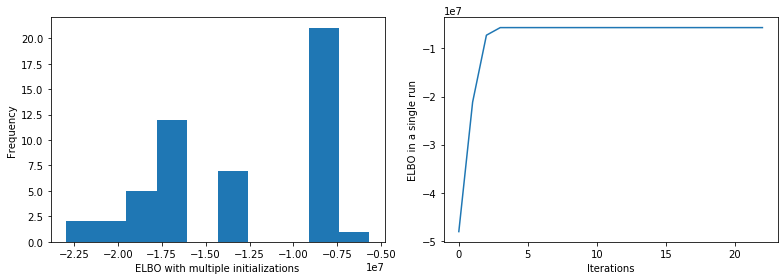

Plotting model
Clustering


ValueError: Format '01' is not supported (supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz)

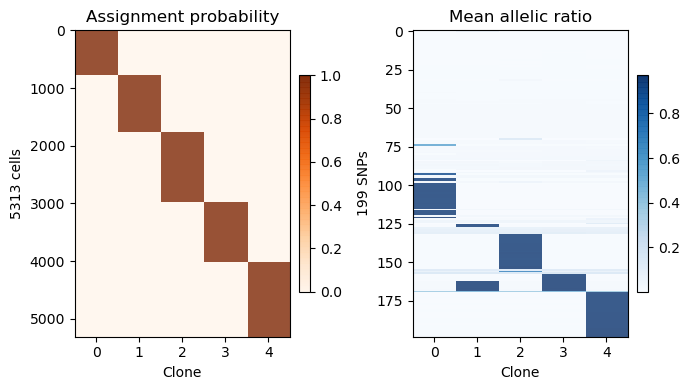

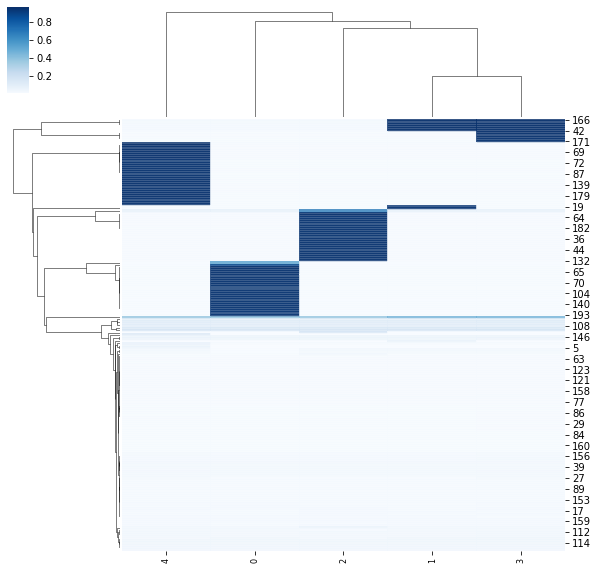

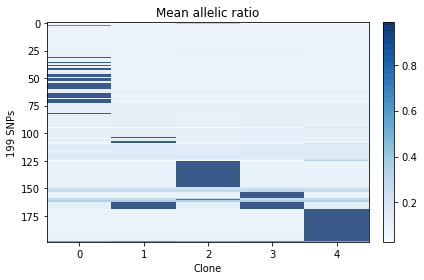

In [12]:
for sample in samples:
    print('sample', sample)
    curr_indir = join(INDIR, f"{sample}_cellSNP_minC{minC}_minAF{minAF}/")
    AD_F = join(curr_indir, "cellSNP.tag.AD.mtx")
    DP_F = join(curr_indir, "cellSNP.tag.DP.mtx")
    #cell_inds_names = join(curr_indir,"cell_indices_*.txt")
    #sample_labels = join(curr_indir, "cell_labels.txt")
    
    print("Loading model")
    AD = mmread(AD_F).tocsc()
    DP = mmread(DP_F).tocsc()
    AD_shape = AD.todense().shape
    print("Running model")
    modelCA = run_vireo(AD, DP, N_DONORS, n_cores=10, plot_qc=True,
                        out_f=join(OUTDIR, sample))
    
    doublet_prob = modelCA.predict_doublet(AD, DP, update_GT=False, update_ID=False)[0].sum(axis=1)
    
    print("Plotting model")
    plot_vireo_out(modelCA, out_f=join(OUTDIR, sample), to_sqrt=False, labels=None,
                       doublet_prob=0.9)

    ## Extract donors
    cell_clusters = extract_clusters(modelCA, prob_thresh=0.9, doublet_thresh=0.9, doublet_prob=doublet_prob,
                                     sample_colors=None, outdir=OUTDIR, out_f=sample)
    
    AF_SNPs = np.sum(modelCA.GT_prob * np.expand_dims(modelCA.beta_mu, 1), axis=2)

    f = plt.figure()
    im = heat_matrix(np.sqrt(AF_SNPs[(AF_SNPs.sum(axis=1)>min_af_sum),:]), 
                     cmap="Blues", alpha=0.8,
                     display_value=False, row_sort=True)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Mean allelic ratio")
    plt.xlabel("Clone")
    plt.ylabel("%d SNPs" % (modelCA.n_var))
    plt.xticks(range(modelCA.n_donor))
    plt.tight_layout()
    plt.savefig(join(OUTDIR, sample+f"_rm{min_af_sum}"))
    #plt.close()
    run_elbo(AD, DP, out_f=join(OUTDIR, "donors_elbo"), n_clone_list=np.arange(N_DONORS-2, N_DONORS+3), 
            n_cores=12, sample_colors=None, save_clusters=False)